Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/training-with-deep-learning/train-hyperparameter-tune-deploy-with-tensorflow/train-hyperparameter-tune-deploy-with-tensorflow.png)

# Training, hyperparameter tune, and deploy with TensorFlow

## Introduction
This tutorial shows how to train a simple deep neural network using the MNIST dataset and TensorFlow on Azure Machine Learning. MNIST is a popular dataset consisting of 70,000 grayscale images. Each image is a handwritten digit of `28x28` pixels, representing number from 0 to 9. The goal is to create a multi-class classifier to identify the digit each image represents, and deploy it as a web service in Azure.

For more information about the MNIST dataset, please visit [Yan LeCun's website](http://yann.lecun.com/exdb/mnist/).

## Prerequisite:
* Understand the [architecture and terms](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture) introduced by Azure Machine Learning
* If you are using an Azure Machine Learning Notebook VM, you are all set. Otherwise, go through the [configuration notebook](../../../configuration.ipynb) to:
    * install the AML SDK
    * create a workspace and its configuration file (`config.json`)

Let's get started. First let's import some Python libraries.

In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
import azureml
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.7.0


## Diagnostics
Opt-in diagnostics for better experience, quality, and security of future releases.

In [3]:
from azureml.telemetry import set_diagnostics_collection

set_diagnostics_collection(send_diagnostics=True)

Turning diagnostics collection on. 


## Initialize workspace
Initialize a [Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace) object from the existing workspace you created in the Prerequisites step. `Workspace.from_config()` creates a workspace object from the details stored in `config.json`.

In [4]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Workspace name: wu2modtimesmlsw
Azure region: westus2
Subscription id: 7fd76d0f-84f2-498b-a997-e0d059af5ce1
Resource group: wu2modtimerg


## Create an Azure ML experiment
Let's create an experiment named "tf-mnist" and a folder to hold the training scripts. The script runs will be recorded under the experiment in Azure.

In [5]:
from azureml.core import Experiment

script_folder = './tf-mnist'
os.makedirs(script_folder, exist_ok=True)

exp = Experiment(workspace=ws, name='tf-mnist')

## Download MNIST dataset
In order to train on the MNIST dataset we will first need to download it from azuremlopendatasets blob directly and save them in a `data` folder locally. If you want you can directly download the same data from Yan LeCun's web site.

In [6]:
import urllib.request

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/train-images-idx3-ubyte.gz',
                           filename=os.path.join(data_folder, 'train-images-idx3-ubyte.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/train-labels-idx1-ubyte.gz',
                           filename=os.path.join(data_folder, 'train-labels-idx1-ubyte.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/t10k-images-idx3-ubyte.gz',
                           filename=os.path.join(data_folder, 't10k-images-idx3-ubyte.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/t10k-labels-idx1-ubyte.gz',
                           filename=os.path.join(data_folder, 't10k-labels-idx1-ubyte.gz'))

('C:\\repos\\git\\MachineLearningNotebooks\\how-to-use-azureml\\ml-frameworks\\tensorflow\\deployment\\train-hyperparameter-tune-deploy-with-tensorflow\\data\\t10k-labels-idx1-ubyte.gz',
 <http.client.HTTPMessage at 0x210511b1908>)

## Show some sample images
Let's load the downloaded compressed file into numpy arrays using some utility functions included in the `utils.py` library file from the current folder. Then we use `matplotlib` to plot 30 random images from the dataset along with their labels.

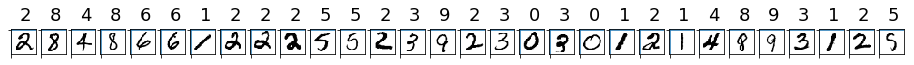

In [7]:
from utils import load_data

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster.
X_train = load_data(os.path.join(data_folder, 'train-images-idx3-ubyte.gz'), False) / np.float32(255.0)
X_test = load_data(os.path.join(data_folder, 't10k-images-idx3-ubyte.gz'), False) / np.float32(255.0)
y_train = load_data(os.path.join(data_folder, 'train-labels-idx1-ubyte.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 't10k-labels-idx1-ubyte.gz'), True).reshape(-1)

count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = y_train[i], fontsize = 18)
    plt.imshow(X_train[i].reshape(28, 28), cmap = plt.cm.Greys)
plt.show()

## Create a Dataset for Files
A Dataset can reference single or multiple files in your datastores or public urls. The files can be of any format. Dataset provides you with the ability to download or mount the files to your compute. By creating a dataset, you create a reference to the data source location. If you applied any subsetting transformations to the dataset, they will be stored in the dataset as well. The data remains in its existing location, so no extra storage cost is incurred. [Learn More](https://aka.ms/azureml/howto/createdatasets)

In [8]:
from azureml.core.dataset import Dataset
web_paths = ['https://azureopendatastorage.blob.core.windows.net/mnist/train-images-idx3-ubyte.gz',
             'https://azureopendatastorage.blob.core.windows.net/mnist/train-labels-idx1-ubyte.gz',
             'https://azureopendatastorage.blob.core.windows.net/mnist/t10k-images-idx3-ubyte.gz',
             'https://azureopendatastorage.blob.core.windows.net/mnist/t10k-labels-idx1-ubyte.gz'
            ]
dataset = Dataset.File.from_files(path = web_paths)

You may want to regiester datasets using the register() method to your workspace so they can be shared with others, reused across various experiments, and referred to by name in your training script.
You can try get the dataset first to see if it's already registered.

In [9]:
dataset_registered = False
try:
    temp = Dataset.get_by_name(workspace = ws, name = 'mnist-dataset')
    dataset_registered = True
except:
    print("The dataset mnist-dataset is not registered in workspace yet.")

if not dataset_registered:
    dataset = dataset.register(workspace = ws,
                               name = 'mnist-dataset',
                               description='training and test dataset',
                               create_new_version=True)
# list the files referenced by dataset
dataset.to_path()

The dataset mnist-dataset is not registered in workspace yet.


['/https/azureopendatastorage.blob.core.windows.net/mnist/train-images-idx3-ubyte.gz',
 '/https/azureopendatastorage.blob.core.windows.net/mnist/t10k-images-idx3-ubyte.gz',
 '/https/azureopendatastorage.blob.core.windows.net/mnist/train-labels-idx1-ubyte.gz',
 '/https/azureopendatastorage.blob.core.windows.net/mnist/t10k-labels-idx1-ubyte.gz']

## Create or Attach existing AmlCompute
You will need to create a [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) for training your model. In this tutorial, you create `AmlCompute` as your training compute resource.

If we could not find the cluster with the given name, then we will create a new cluster here. We will create an `AmlCompute` cluster of `STANDARD_NC6` GPU VMs. This process is broken down into 3 steps:
1. create the configuration (this step is local and only takes a second)
2. create the cluster (this step will take about **20 seconds**)
3. provision the VMs to bring the cluster to the initial size (of 1 in this case). This step will take about **3-5 minutes** and is providing only sparse output in the process. Please make sure to wait until the call returns before moving to the next cell

In [10]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "gpu-cluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6', 
                                                           max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it uses the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Found existing compute target
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2020-06-25T22:57:32.180000+00:00', 'errors': None, 'creationTime': '2020-01-15T19:21:21.333672+00:00', 'modifiedTime': '2020-01-15T19:21:36.994850+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 6, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NC6'}


Now that you have created the compute target, let's see what the workspace's `compute_targets` property returns. You should now see one entry named 'gpu-cluster' of type `AmlCompute`.

In [11]:
compute_targets = ws.compute_targets
for name, ct in compute_targets.items():
    print(name, ct.type, ct.provisioning_state)

loan-classifier VirtualMachine Succeeded
pfg VirtualMachine Succeeded
cpucluster AmlCompute Succeeded
gpucluster AmlCompute Succeeded
cpu-cluster AmlCompute Succeeded
gpu-cluster AmlCompute Succeeded
gpunotebooks ComputeInstance Succeeded
githubcluster AmlCompute Succeeded


## Copy the training files into the script folder
The TensorFlow training script is already created for you. You can simply copy it into the script folder, together with the utility library used to load compressed data file into numpy array.

In [12]:
import shutil

# the training logic is in the tf_mnist.py file.
shutil.copy('./tf_mnist.py', script_folder)

# the utils.py just helps loading data from the downloaded MNIST dataset into numpy arrays.
shutil.copy('./utils.py', script_folder)

'./tf-mnist\\utils.py'

## Construct neural network in TensorFlow
In the training script `tf_mnist.py`, it creates a very simple DNN (deep neural network), with just 2 hidden layers. The input layer has 28 * 28 = 784 neurons, each representing a pixel in an image. The first hidden layer has 300 neurons, and the second hidden layer has 100 neurons. The output layer has 10 neurons, each representing a targeted label from 0 to 9.

![DNN](nn.png)

### Azure ML concepts  
Please note the following three things in the code below:
1. The script accepts arguments using the argparse package. In this case there is one argument `--data_folder` which specifies the file system folder in which the script can find the MNIST data
```
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_folder')
```
2. The script is accessing the Azure ML `Run` object by executing `run = Run.get_context()`. Further down the script is using the `run` to report the training accuracy and the validation accuracy as training progresses.
```
    run.log('training_acc', np.float(acc_train))
    run.log('validation_acc', np.float(acc_val))
```
3. When running the script on Azure ML, you can write files out to a folder `./outputs` that is relative to the root directory. This folder is specially tracked by Azure ML in the sense that any files written to that folder during script execution on the remote target will be picked up by Run History; these files (known as artifacts) will be available as part of the run history record.

The next cell will print out the training code for you to inspect it.

In [13]:
with open(os.path.join(script_folder, './tf_mnist.py'), 'r') as f:
    print(f.read())

# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

import numpy as np
import argparse
import os
import re
import tensorflow as tf
import time
import glob

from azureml.core import Run
from utils import load_data
from tensorflow.keras import Model, layers


# Create TF Model.
class NeuralNet(Model):
    # Set layers.
    def __init__(self):
        super(NeuralNet, self).__init__()
        # First hidden layer.
        self.h1 = layers.Dense(n_h1, activation=tf.nn.relu)
        # Second hidden layer.
        self.h2 = layers.Dense(n_h2, activation=tf.nn.relu)
        self.out = layers.Dense(n_outputs)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = self.h1(x)
        x = self.h2(x)
        x = self.out(x)
        if not is_training:
            # Apply softmax when not training.
            x = tf.nn.softmax(x)
        return x


def cross_entropy_loss(y, logits):
    # Convert labels to int 64 for tf cross-entro

## Create TensorFlow estimator
Next, we construct an `azureml.train.dnn.TensorFlow` estimator object, use the Batch AI cluster as compute target, and pass the mount-point of the datastore to the training code as a parameter.

The TensorFlow estimator is providing a simple way of launching a TensorFlow training job on a compute target. It will automatically provide a docker image that has TensorFlow installed -- if additional pip or conda packages are required, their names can be passed in via the `pip_packages` and `conda_packages` arguments and they will be included in the resulting docker.

The TensorFlow estimator also takes a `framework_version` parameter -- if no version is provided, the estimator will default to the latest version supported by AzureML. Use `TensorFlow.get_supported_versions()` to get a list of all versions supported by your current SDK version or see the [SDK documentation](https://docs.microsoft.com/en-us/python/api/azureml-train-core/azureml.train.dnn?view=azure-ml-py) for the versions supported in the most current release.

In [26]:
from azureml.train.dnn import TensorFlow

script_params = {
    '--data-folder': dataset.as_named_input('mnist').as_mount(),
    '--batch-size': 64,
    '--first-layer-neurons': 256,
    '--second-layer-neurons': 128,
    '--learning-rate': 0.01
}

est = TensorFlow(source_directory=script_folder,
                 script_params=script_params,
                 compute_target=compute_target,
                 entry_script='tf_mnist.py',
                 use_gpu=True,
                 framework_version='2.1',
                 pip_packages=['azureml-dataprep[pandas,fuse]','tensorflow-gpu==2.2.0'])

WARNING - You have specified to install packages in your run. Note that you have overridden Azure ML's installation of the following packages: ['tensorflow-gpu']. We cannot guarantee image build will succeed.


## Submit job to run
Submit the estimator to an Azure ML experiment to kick off the execution.

In [27]:
run = exp.submit(est)

### Monitor the Run <a class="anchor" id="monitor-run"></a>
As the Run is executed, it will go through the following stages:
1. Preparing: A docker image is created matching the Python environment specified by the TensorFlow estimator and it will be uploaded to the workspace's Azure Container Registry. This step will only happen once for each Python environment -- the container will then be cached for subsequent runs. Creating and uploading the image takes about **5 minutes**. While the job is preparing, logs are streamed to the run history and can be viewed to monitor the progress of the image creation.

2. Scaling: If the compute needs to be scaled up (i.e. the Batch AI cluster requires more nodes to execute the run than currently available), the cluster will attempt to scale up in order to make the required amount of nodes available. Scaling typically takes about **5 minutes**.

3. Running: All scripts in the script folder are uploaded to the compute target, data stores are mounted/copied and the `entry_script` is executed. While the job is running, stdout and the `./logs` folder are streamed to the run history and can be viewed to monitor the progress of the run.

4. Post-Processing: The `./outputs` folder of the run is copied over to the run history

There are multiple ways to check the progress of a running job. We can use a Jupyter notebook widget. 

**Note: The widget will automatically update ever 10-15 seconds, always showing you the most up-to-date information about the run**

In [28]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

We can also periodically check the status of the run object, and navigate to Azure portal to monitor the run.

In [29]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
tf-mnist,tf-mnist_1593127650_217d3343,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


In [30]:
run.wait_for_completion(show_output=True)

RunId: tf-mnist_1593127650_217d3343
Web View: https://ml.azure.com/experiments/tf-mnist/runs/tf-mnist_1593127650_217d3343?wsid=/subscriptions/7fd76d0f-84f2-498b-a997-e0d059af5ce1/resourcegroups/wu2modtimerg/workspaces/wu2modtimesmlsw

Streaming azureml-logs/20_image_build_log.txt

2020/06/25 23:27:37 Downloading source code...
2020/06/25 23:27:38 Finished downloading source code
2020/06/25 23:27:39 Creating Docker network: acb_default_network, driver: 'bridge'
2020/06/25 23:27:39 Successfully set up Docker network: acb_default_network
2020/06/25 23:27:39 Setting up Docker configuration...
2020/06/25 23:27:40 Successfully set up Docker configuration
2020/06/25 23:27:40 Logging in to registry: wu2modtimesmls5288786732.azurecr.io
2020/06/25 23:27:40 Successfully logged into wu2modtimesmls5288786732.azurecr.io
2020/06/25 23:27:40 Executing step ID: acb_step_0. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2020/06/25 23:27:40 Scanning for dependencies...
2020/06/

Removing intermediate container 5b0ea7eae76c
 ---> a19b108bc66b
Step 9/14 : ENV PATH /azureml-envs/azureml_7fd238c9cddda6fa149db3c75a94ccc3/bin:$PATH
 ---> Running in f327f3a40a32
Removing intermediate container f327f3a40a32
 ---> 88e1ad5c616d
Step 10/14 : ENV AZUREML_CONDA_ENVIRONMENT_PATH /azureml-envs/azureml_7fd238c9cddda6fa149db3c75a94ccc3
 ---> Running in c12b5e45020f
Removing intermediate container c12b5e45020f
 ---> f05059940df0
Step 11/14 : ENV LD_LIBRARY_PATH /azureml-envs/azureml_7fd238c9cddda6fa149db3c75a94ccc3/lib:$LD_LIBRARY_PATH
 ---> Running in 0e0b24b8f199
Removing intermediate container 0e0b24b8f199
 ---> e02a846efa81
Step 12/14 : COPY azureml-environment-setup/spark_cache.py azureml-environment-setup/log4j.properties /azureml-environment-setup/
 ---> 1600a8f22c28
Step 13/14 : ENV AZUREML_ENVIRONMENT_IMAGE True
 ---> Running in 820090f09735
Removing intermediate container 820090f09735
 ---> 5fb765e2f35e
Step 14/14 : CMD ["bash"]
 ---> Running in c2b012564a92
Removing 


Streaming azureml-logs/75_job_post-tvmps_dec38e26a23aa07bf563c13e9e3e5a7f583b1f5e22bda170dcf8418d4f72e828_d.txt

Entering job release. Current time:2020-06-25T23:44:53.045891
Starting job release. Current time:2020-06-25T23:44:53.848062
Logging experiment finalizing status in history service.
Starting the daemon thread to refresh tokens in background for process with pid = 628
Entering context manager injector. Current time:2020-06-25T23:44:53.867204
Job release is complete. Current time:2020-06-25T23:44:57.439965

Execution Summary
RunId: tf-mnist_1593127650_217d3343
Web View: https://ml.azure.com/experiments/tf-mnist/runs/tf-mnist_1593127650_217d3343?wsid=/subscriptions/7fd76d0f-84f2-498b-a997-e0d059af5ce1/resourcegroups/wu2modtimerg/workspaces/wu2modtimesmlsw



{'runId': 'tf-mnist_1593127650_217d3343',
 'target': 'gpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2020-06-25T23:40:38.7312Z',
 'endTimeUtc': '2020-06-25T23:45:05.342766Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '28da1ffc-b78c-40e4-bb86-820d8b30730e',
  'azureml.git.repository_uri': 'https://github.com/Azure/MachineLearningNotebooks.git',
  'mlflow.source.git.repoURL': 'https://github.com/Azure/MachineLearningNotebooks.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '053efde8c9740c7b691c4d13ee1f5b5b206cd24f',
  'mlflow.source.git.commit': '053efde8c9740c7b691c4d13ee1f5b5b206cd24f',
  'azureml.git.dirty': 'True',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': 'ee73c186-95ee-44f1-9577-c5dd16f12d8d'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'mnist', 'mechanism

### The Run object <a class="anchor" id="run-object"></a>
The Run object provides the interface to the run history -- both to the job and to the control plane (this notebook), and both while the job is running and after it has completed. It provides a number of interesting features for instance:
* `run.get_details()`: Provides a rich set of properties of the run
* `run.get_metrics()`: Provides a dictionary with all the metrics that were reported for the Run
* `run.get_file_names()`: List all the files that were uploaded to the run history for this Run. This will include the `outputs` and `logs` folder, azureml-logs and other logs, as well as files that were explicitly uploaded to the run using `run.upload_file()`

Below are some examples -- please run through them and inspect their output. 

In [ ]:
run.get_details()

In [ ]:
run.get_metrics()

In [ ]:
run.get_file_names()

## Plot accuracy over epochs
Since we can retrieve the metrics from the run, we can easily make plots using `matplotlib` in the notebook. Then we can add the plotted image to the run using `run.log_image()`, so all information about the run is kept together.

In [ ]:

os.makedirs('./imgs', exist_ok=True)
metrics = run.get_metrics()

plt.figure(figsize = (13,5))
plt.plot(metrics['validation_acc'], 'r-', lw=4, alpha=.6)
plt.plot(metrics['training_acc'], 'b--', alpha=0.5)
plt.legend(['Full evaluation set', 'Training set mini-batch'])
plt.xlabel('epochs', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('Accuracy over Epochs', fontsize=16)
run.log_image(name='acc_over_epochs.png', plot=plt)
plt.show()

## Download the saved model

In the training script, a TensorFlow `saver` object is used to persist the model in a local folder (local to the compute target). The model was saved to the `./outputs` folder on the disk of the Batch AI cluster node where the job is run. Azure ML automatically uploaded anything written in the `./outputs` folder into run history file store. Subsequently, we can use the `Run` object to download the model files the `saver` object saved. They are under the the `outputs/model` folder in the run history file store, and are downloaded into a local folder named `model`. Note the TensorFlow model consists of four files in binary format and they are not human-readable.

In [ ]:
run.download_files(prefix='outputs/model', output_directory='./model', append_prefix=False)

## Predict on the test set
Now load the saved TensorFlow graph, and list all operations under the `network` scope. This way we can discover the input tensor `network/X:0` and the output tensor `network/output/MatMul:0`, and use them in the scoring script in the next step.

Note: if your local TensorFlow version is different than the version running in the cluster where the model is trained, you might see a "compiletime version mismatch" warning. You can ignore it.

In [ ]:
import tensorflow as tf
imported_model = tf.saved_model.load('./model')

In [ ]:
pred =imported_model(X_test)
y_hat = np.argmax(pred, axis=1)

# print the first 30 labels and predictions
print('labels:  \t', y_test[:30])
print('predictions:\t', y_hat[:30])

In [ ]:
print("Accuracy on the test set:", np.average(y_hat == y_test))

In [ ]:
print("Accuracy on the test set:", np.average(y_hat == y_test))

## Intelligent hyperparameter tuning
We have trained the model with one set of hyperparameters, now let's how we can do hyperparameter tuning by launching multiple runs on the cluster. First let's define the parameter space using random sampling.

In [ ]:
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, loguniform

ps = RandomParameterSampling(
    {
        '--batch-size': choice(32, 64, 128),
        '--first-layer-neurons': choice(16, 64, 128, 256, 512),
        '--second-layer-neurons': choice(16, 64, 256, 512),
        '--learning-rate': loguniform(-6, -1)
    }
)

Next, we will create a new estimator without the above parameters since they will be passed in later. Note we still need to keep the `data-folder` parameter since that's not a hyperparamter we will sweep.

In [ ]:
est = TensorFlow(source_directory=script_folder,
                 script_params={'--data-folder': dataset.as_named_input('mnist').as_mount()},
                 compute_target=compute_target,
                 entry_script='tf_mnist.py',
                 framework_version='2.0',
                 use_gpu=True,
                 pip_packages=['azureml-dataprep[pandas,fuse]'])

Now we will define an early termnination policy. The `BanditPolicy` basically states to check the job every 2 iterations. If the primary metric (defined later) falls outside of the top 10% range, Azure ML terminate the job. This saves us from continuing to explore hyperparameters that don't show promise of helping reach our target metric.

In [ ]:
policy = BanditPolicy(evaluation_interval=2, slack_factor=0.1)

Now we are ready to configure a run configuration object, and specify the primary metric `validation_acc` that's recorded in your training runs. If you go back to visit the training script, you will notice that this value is being logged after every epoch (a full batch set). We also want to tell the service that we are looking to maximizing this value. We also set the number of samples to 20, and maximal concurrent job to 4, which is the same as the number of nodes in our computer cluster.

In [ ]:
htc = HyperDriveConfig(estimator=est, 
                       hyperparameter_sampling=ps, 
                       policy=policy, 
                       primary_metric_name='validation_acc', 
                       primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                       max_total_runs=8,
                       max_concurrent_runs=4)

Finally, let's launch the hyperparameter tuning job.

In [ ]:
htr = exp.submit(config=htc)

We can use a run history widget to show the progress. Be patient as this might take a while to complete.

In [ ]:
RunDetails(htr).show()

In [ ]:
htr.wait_for_completion(show_output=True)

In [ ]:
assert(htr.get_status() == "Completed")

## Warm start a Hyperparameter Tuning experiment and resuming child runs
Often times, finding the best hyperparameter values for your model can be an iterative process, needing multiple tuning runs that learn from previous hyperparameter tuning runs. Reusing knowledge from these previous runs will accelerate the hyperparameter tuning process, thereby reducing the cost of tuning the model and will potentially improve the primary metric of the resulting model. When warm starting a hyperparameter tuning experiment with Bayesian sampling, trials from the previous run will be used as prior knowledge to intelligently pick new samples, so as to improve the primary metric. Additionally, when using Random or Grid sampling, any early termination decisions will leverage metrics from the previous runs to determine poorly performing training runs. 

Azure Machine Learning allows you to warm start your hyperparameter tuning run by leveraging knowledge from up to 5 previously completed hyperparameter tuning parent runs. 

Additionally, there might be occasions when individual training runs of a hyperparameter tuning experiment are cancelled due to budget constraints or fail due to other reasons. It is now possible to resume such individual training runs from the last checkpoint (assuming your training script handles checkpoints). Resuming an individual training run will use the same hyperparameter configuration and mount the storage used for that run. The training script should accept the "--resume-from" argument, which contains the checkpoint or model files from which to resume the training run. You can also resume individual runs as part of an experiment that spends additional budget on hyperparameter tuning. Any additional budget, after resuming the specified training runs is used for exploring additional configurations.

For more information on warm starting and resuming hyperparameter tuning runs, please refer to the [Hyperparameter Tuning for Azure Machine Learning documentation](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-tune-hyperparameters) 

## Find and register best model <a class="anchor" id="register-model"></a>
When all the jobs finish, we can find out the one that has the highest accuracy.

In [ ]:
best_run = htr.get_best_run_by_primary_metric()

Now let's list the model files uploaded during the run.

In [ ]:
print(best_run.get_file_names())

We can then register the folder (and all files in it) as a model named `tf-dnn-mnist` under the workspace for deployment.

In [ ]:
model = best_run.register_model(model_name='tf-dnn-mnist', model_path='outputs/model')

## Deploy the model in ACI
Now we are ready to deploy the model as a web service running in Azure Container Instance [ACI](https://azure.microsoft.com/en-us/services/container-instances/). Azure Machine Learning accomplishes this by constructing a Docker image with the scoring logic and model baked in.
### Create score.py
First, we will create a scoring script that will be invoked by the web service call. 

* Note that the scoring script must have two required functions, `init()` and `run(input_data)`. 
  * In `init()` function, you typically load the model into a global object. This function is executed only once when the Docker container is started. 
  * In `run(input_data)` function, the model is used to predict a value based on the input data. The input and output to `run` typically use JSON as serialization and de-serialization format but you are not limited to that.

In [ ]:
%%writefile score.py
import json
import numpy as np
import os
import tensorflow as tf

from azureml.core.model import Model

def init():
    global tf_model
    model_root = os.getenv('AZUREML_MODEL_DIR')
    # the name of the folder in which to look for tensorflow model files
    tf_model_folder = 'model'
    
    tf_model = tf.saved_model.load(os.path.join(model_root, tf_model_folder))

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'], dtype=np.float32)
    
    # make prediction
    out = tf_model(data)
    y_hat = np.argmax(out, axis=1)

    return y_hat.tolist()

### Create myenv.yml
We also need to create an environment file so that Azure Machine Learning can install the necessary packages in the Docker image which are required by your scoring script. In this case, we need to specify packages `numpy`, `tensorflow`.

In [ ]:
from azureml.core.runconfig import CondaDependencies

cd = CondaDependencies.create()
cd.add_conda_package('numpy')
cd.add_pip_package('tensorflow==2.0.0')
cd.add_pip_package("azureml-defaults")
cd.save_to_file(base_directory='./', conda_file_path='myenv.yml')

print(cd.serialize_to_string())

### Deploy to ACI
We are almost ready to deploy. Create the inference configuration and deployment configuration and deploy to ACI. This cell will run for about 7-8 minutes.

In [ ]:
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.model import Model
from azureml.core.environment import Environment


myenv = Environment.from_conda_specification(name="myenv", file_path="myenv.yml")
inference_config = InferenceConfig(entry_script="score.py", environment=myenv)

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={'name':'mnist', 'framework': 'TensorFlow DNN'},
                                               description='Tensorflow DNN on MNIST')

service = Model.deploy(workspace=ws, 
                           name='tf-mnist-svc', 
                           models=[model], 
                           inference_config=inference_config, 
                           deployment_config=aciconfig)

service.wait_for_deployment(True)
print(service.state)

**Tip: If something goes wrong with the deployment, the first thing to look at is the logs from the service by running the following command:**

In [ ]:
print(service.get_logs())

This is the scoring web service endpoint:

In [ ]:
print(service.scoring_uri)

### Test the deployed model
Let's test the deployed model. Pick 30 random samples from the test set, and send it to the web service hosted in ACI. Note here we are using the `run` API in the SDK to invoke the service. You can also make raw HTTP calls using any HTTP tool such as curl.

After the invocation, we print the returned predictions and plot them along with the input images. Use red font color and inversed image (white on black) to highlight the misclassified samples. Note since the model accuracy is pretty high, you might have to run the below cell a few times before you can see a misclassified sample.

In [ ]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y=-10, s=y_hat[s], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

We can also send raw HTTP request to the service.

In [ ]:
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type':'application/json'}

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

Let's look at the workspace after the web service was deployed. You should see 
* a registered model named 'model' and with the id 'model:1'
* a webservice called 'tf-mnist' with some scoring URL

In [ ]:
model = ws.models['tf-dnn-mnist']
print("Model: {}, ID: {}".format('tf-dnn-mnist', model.id))
    
webservice = ws.webservices['tf-mnist-svc']
print("Webservice: {}, scoring URI: {}".format('tf-mnist-svc', webservice.scoring_uri))

## Clean up
You can delete the ACI deployment with a simple delete API call.

In [ ]:
service.delete()